# Collective Animal Behavior and Diffusion Maps

## Introduction

The traditional understanding of physical systems has been heavily influenced by the notion that symmetry dictates the organization of matter within the universe. However, the recent surge in quantitative measurements and analyses across a wide range of complex systems—including living organisms and social networks—is challenging this long-held intuition.  While complex systems obey the same fundamental laws as classical matter, they are distinguished by their large number of heterogeneous components which interact through non-trivial rules and more importantly they are typically out of thermodynamic equilibrium, which rules out the use of conservation laws to study the evolution of such systems.

Despite their complexity, biological systems often exhibit low-dimensional dynamics, as exemplified in cases of collective behavior, where the collective state evolves on timescales longer than individual interactions. However, identifying the relevant order parameters governing these collective states is not always straightforward. In some cases, statistical moments of microscopic variables, such as average orientation in flocking systems, can serve as order parameters. However, in many biological systems, the transitions are not driven by changes in the statistical moments but instead arise from modifications in the underlying interaction network topology due to aging, external stimuli, or changes in the ecological context.

In the absence of clear symmetries, identifying the appropriate coarse-grained variables for a collective system remains a difficult task. Traditional approaches often rely on intuition or specific knowledge of the underlying biological processes, making them system-specific and inefficient.  Machine learning (ML) offers a promising alternative, with its ability to detect patterns in large datasets and extract relevant features.  While ML has seen success in various fields, including image and speech recognition, protein folding, and even many-body physics, its application to biological systems remains relatively unexplored, with only a few examples using artificial datasets.  In this tutorial, we leverage diffusion maps, an unsupervised ML technique for manifold learning and dimensionality reduction, to systematically identify the coarse-grained dynamics and potential order parameters in biological collective systems.

## Method
We consider the evolution of a collection of interacting particles, $A=\{a_i\}_{i=1}^{n}$, as a dynamical system. Each experimental observation of $A$, yields a state vector $X(t)=\left(x_1(t), x_2(t),\ldots, x_n(t) \right)$, where the features $x_i(t)$ represent measurements specific to the system under study. These measurements might encompass, for instance, the position and the velocity, $x_i = (\mathbf{x}_i,\mathbf{v}_i)$, of the $i$-th bird in a flock of starlings or the activity of the $i$-th neuron in a neural network. Subsequent observations of $A$ generate a discrete time series $\mathcal{X}=\left\{X_i\right\}_{i=1}^{N}=\left\{X(t_i)\right\}_{i=1}^{N}$, that represents a sampling of a trajectory in the associated phase space $\mathcal{S}$ (see Fig.1).

<figure style="display: flex; flex-direction:column; justify-content: center; align-items: center; gap: 20px">
    <img style="width: 16cm; background-color: white" src = "./method01_1.png" />
</figure>

*Figure 1. Dynamical systems interpretation of the collective behavior of a system of interacting particles $A$. (a) An experimental observation of $A$ at a given time $t$ is represented by the feature vector $X(t)$. Here, we use schooling juvenile zebra fish D. rerio as an illustration. In this case, the feature vectors consist of the positions and velocities of each individual in $A$, that is $x_i=(\mathbf{x}_i, \mathbf{v}_i)$. (b) In the presence of a collective state, the state space $\mathcal{S}$ contains structures such as $K_+$ and $K_-$ which correspond to swirling states with positive and negative angular momentum in the case of the schooling fish. The density of states is highly concentrated around the attractors $X_\pm$. This allows us to use clustering techniques to identify the collective states $K_\pm$ with positive and negative angular momentum. The background color gradient represents the density of states in $\mathcal{S}$, it is higher around the attractors $X_{\pm}$ and negligible around the isotropic configurations with random orientations, for example $X_0$ and $\tilde{X}_0$.*

The figure above shows configurations of a group of juvenile zebra fish at different times. In this case $a_i$ represents the $i$-th fish in the group and the state vector consists of all their positions and velocities at a given time, that is $x_i = (\mathbf{x}_i, \mathbf{v}_i)$. The data was provided by [__Romero Ferrero et al.__](https://www.nature.com/articles/s41592-018-0295-5) and [__Heras et al.__](https://journals.plos.org/ploscompbiol/article?id=10.1371/journal.pcbi.1007354) who studied the application of machine vision to track individuals in groups of zebra fish. We replaced missing values in the tracked data using a cubic spline interpolator and we calculate the velocity using a [__noisy derivative scheme of fifth order__](http://www.holoborodko.com/pavel/numerical-methods/numerical-derivative/smooth-low-noise-differentiators/).

In [1]:
#Let's import the curated data
import csv

def readData(source):
    data=[]
    '''
    The data is in the format
    [x11,y11], [x12,y12], ...
    [x21,y21], [x22,y22], ...
    ...
    [xn1,yn1], [xn2,yn2] ...
    '''
    with open(source, newline='') as csvfile:
        reader = csv.reader(csvfile,delimiter=',')
        
        for row in reader:
            row_data = []
            for i in range(0, len(row), 2):  # Process pairs
                x = float(row[i].strip("[]"))
                y = float(row[i+1].strip("[]"))
                row_data.append([x, y])
            data.append(row_data)
        
        return data
            

In [2]:
positions = readData('./fish-positions-100.csv')
velocities = readData('./fish-velocities-100.csv')

In [3]:
#Let's transform these to numpy arrays so that we can manipulate them more easily
import numpy as np
np_pos = np.array(positions)
np_vel = np.array(velocities)

To imbue $\mathcal{S}$ with a metric structure, we define a distance function between states $X\in\mathcal{S}$. While the Euclidean distance $d^2(X,\tilde{X})=|X-\tilde{X}|^2=\sum_i{(x_{i}-\tilde{x}_{i})^2}$ is a natural choice, it may be inappropriate if the system exhibits symmetries. In such cases, similar states could be erroneously separated by large distances within $\mathcal{S}$. To address this, we preprocess the data leveraging symmetry-invariant features. Specifically, for the symmetry transformation $T$, we construct feature vectors $Y=\left(y_1, y_2,\ldots, y_m \right)$ using a suitable transformation $F$, such that $y_i=F(Tx_1,Tx_2,\ldots,Tx_n)=F(x_1,x_2,\ldots,x_n)$. This transformation yields a modified representation of the state space, denoted as $\mathcal{S}_Y$, wherein the Euclidean distance $|Y-\tilde{Y}|$ can reliably quantify the similarity between states [see Fig.2].

The fish data set is invariant under relabeling of the individuals, therefore we need to choose features that are invariant under permutations of the positions and velocities. The easiest option is to take the statistical moments of the configurations. This might seem like cheating, but note that we still haven't made any assumption about the nature of the interactions between individuals, these is purely an argument about the data. We also need to take care of the fact that we are mixing physical dimensions (length, velocity), we can take care of this by scaling the positions and velocities by the size of the tank and the maximum velocity.

In [4]:
def normalize_data(data_array):
    """Normalizes each coordinate within each row of a 3D array to the range [-1, 1].

    Args:
        data_array: A NumPy array of shape (num_rows, num_points, 2) representing x,y coordinates.

    Returns:
        A NumPy array of the same shape as data_array, but with values normalized to [-1, 1].
    """
    normalized_data = np.zeros_like(data_array)  # Create an array of the same shape

    for i, row in enumerate(data_array):
        #We don't know the exact dimension of the tank but we can infer it by the max and min values of the position
        min_vals = np.min(row, axis=0)  # Find min for each coordinate in the row 
        max_vals = np.max(row, axis=0)  # Find max for each coordinate in the row

        # Normalize each coordinate to [0, 1]
        normalized_row = (row - min_vals) / (max_vals - min_vals)  

        # Scale and shift to [-1, 1]
        normalized_data[i] = 2 * normalized_row - 1  

    return normalized_data

In [5]:
normalized_pos = normalize_data(np_pos)
normalized_vel = normalize_data(np_vel)

In [6]:
#Let's combine the positions and velocities
xv_features = np.array([np.concatenate((row1, row2), axis=1) for row1, row2 in zip(normalized_pos, normalized_vel)])

In [7]:
#Now we calculate the moments at each time step
def calculate_moments(data_array):
    """
    Calculates the mean and covariance matrix for each row of a 3D array.

    Args:
        data_array: A NumPy array with shape (num_rows, num_points, 4) where the last dimension 
                    represents (x, y, u, v) coordinates.

    Returns:
        A NumPy array with shape (num_rows, 14) where each row contains the mean of x, y, u, v, 
        and the unique elements of the covariance matrix.
    """
    results = []
    for row in data_array:

        # Calculate mean and covariance
        meanZ = np.mean(row, axis=0)  
        covZ = np.cov(row, rowvar=False) 

        # Extract and flatten results
        moments = np.concatenate((meanZ, covZ[np.triu_indices(covZ.shape[0])])) 
        results.append(moments)
    return np.array(results)

moment_features = calculate_moments(xv_features)

Intuitively, when the collection $A$ develops a collective state, we expect the existence of atracttors or slow manifolds in $\mathcal{S}$. If the trajectories are sampled at a fixed frame-rate $\tau=t_{i+1}-t_i$, then the density of states will be higher around the attractors or along the slow manifolds (Fig.1). In such a case, dimensionality reduction techniques, such as PCA, $k$-means, UMAP, or spectral clustering, can be employed to identify the attractors. Among these techniques, spectral clustering through diffusion maps offers a distinct advantage: the eigenfunctions of the diffusion map can be interpreted as the slow variables of the system. To support this claim, consider the following argument:

<figure style="display: flex; flex-direction:column; justify-content: center; align-items: center; gap: 20px">
    <img style="width: 16cm; background-color: white" src = "./method02.png" />
</figure>

*Figure 2. Construction of the transition matrix for the diffusion process. (a) When we use the naive feature vectors, $X(t)$, together with the euclidean distance $|X-\tilde{X}|$,the representation $\mathcal{S}_X$ of the state spaces yields erroneously large distances between two equivalent states. For instance, the vectors $X_i = (x_1(t_i), x_2(t_i),\ldots,x_n(t_i))$ and $X'_i = (x_{\sigma(1)}(t_i),x_{\sigma(2)}(t_i),\ldots,x_{\sigma(n)})$, where $\sigma$ is a permutation of the set $\{1,2,\ldots,n\}$ represent the same configuration of schooling zebra fish, however this are far away from each other in $\mathcal{S}_X$. (b) To address symmetries, we use symmetry-invariant feature vectors $Y_i = F(X_i)$ that yield the representation $\mathcal{S}_Y$ where $Y_i$ and $Y'_i$ represent the same state. On $\mathcal{S}_Y$ we construct a fully connected graph $\mathcal{G}_Y$ with vertices $Y_i$ and edges with weights $p^{\epsilon}_{i,j}$ which depend on the distance $d_{i,j} = |Y_i-Y_j|$ through the Gaussian kernel $K_{\epsilon}(d) = \mathcal{N}e^{-d^2/\epsilon}$, where $\mathcal{N}$ is a normalization factor. The adjacency matrix of $\mathcal{G}_Y$, given by $P_{\epsilon} = p^{\epsilon}_{i,j}$ is called the transition probability matrix and it defines a fictitious diffusion process on $\mathcal{S}_Y$ with diffusivity $\epsilon$. Intuitively, two states will have a high probability of transitioning into each other if their distance is less than the diffusion length $\epsilon\Delta t$.*

The diffusion map is generated through a fictitious discrete hopping process on a complete graph $\mathcal{G}_Y$ with vertices $Y_i$. Each edge of this graph is weighted according to a symmetric kernel $K(d_{i,j})=K(d(Y_i,Y_j))$ and the row-column normalized adjacency matrix of the weighted graph can be interpreted as a transition probability matrix $\mathbf{P}$, with each entry $p^{\epsilon}_{ij}\propto \exp{(-d_{i,j}^2/\epsilon)}$ representing the hopping rate between $Y_i$ and $Y_j$ (for details see [__Coifman and Lafon 2006__](https://www.sciencedirect.com/science/article/pii/S1063520306000546)).

Note that distributions on the data space (the vertices of the graph) are represented by vectors $\mathbf{v}\in\mathbb{R}^{N}$, such that $\sum_i{v_i}=1$. Therefore a data point $Y_i$ can be represented by the canonical vector $\mathbf{e}_i\in\mathbb{R}^{N}$ with entries $e_{i,j}=\delta_{ij}$, where $\delta_{ij}$ is the Kroenecker delta. Working under the assumption that the real trajectories are smooth, we should expect $Y_i$ and $Y_{i+1}$ to be close so that the trajectory $\mathcal{Z}_i=\{Z_{i}^{j}|Z_{i}^{j}\sim P^{j}\mathbf{e}_i\}_{j=0}^{m}$ approximates the real trajectory $\mathcal{Y}_i=\{Y_{i+j}\}_{j=0}^{m}$ (see Fig.3). Here we use, $\sim$, to denote "distributed according to", in other words $Z_{i}^{j}$ is sampled from the distribution $P^{j}\mathbf{e}_i$. Since points close together have a higher transition probability, the trajectories $\mathcal{Z}$, generated through repeated application of $P$, will linger around the attractors for long periods of time. To complete the argument, we need to show that the eigenvectors are slow variables of the fictitious diffusion process.

Given that the transition rate between data points decays exponentially with increasing distance $d$, we can relabel the data points in such a way that $P$ becomes an almost block matrix. In this form, the ratios of the off-diagonal block entries to the diagonal block entries become negligible, on the order of $\delta\ll1$, as depicted in Fig.3. The diagonal blocks of $P$ correspond to clusters of strongly connected vertices in the graph representation Fig. 2.

Furthermore, the spectrum of $P$, being a doubly stochastic matrix, includes an eigenvalue $\lambda_1=1$. Additionally, there exist $k-1$ dominant eigenvalues $\lambda_k\sim\mathcal{O}(1)$, where $k$ represents the number of clusters in the graph, tipically satisfying $k\ll n$. The remaining eigenvalues are separated by a spectral gap $\Delta\lambda$, such that $1-\Delta\lambda\ll1$ (Fig.3). By expressing the delta peaked distribution $\mathbf{e}_i$ as a linear combination of the eigenfunctions, $\psi_j$, of $P$, we obtain the following approximation:
\begin{equation}
Z_{i}^{m}\sim\sum_{j=1}^{N}{\lambda_j^m\frac{\psi_{j,i}}{|\psi_{j}|^2}\psi_{j}}=\sum_{j=1}^{k}{\lambda_j^m\frac{\psi_{j,i}}{|\psi_{j}|^2}\psi_{j}}+\mathcal{O}(\delta^m).
\end{equation}
For sufficiently long times, the probability that the trajectory $\mathcal{Z}$ residing within the linear span of the dominant eigenfunctions, $\mathcal{L}^{k}=\left\langle\{\psi_i\}_{i=2}^{k}\right\rangle$, becomes exceedingly high, as $\delta^m\lll1$. This observation permits the interpretation of the eigenfunctions $\psi_j$ as the slow variables governing the fictitious diffusion process. Given that $\mathcal{Z}$ closely approximates the actual trajectory $\mathcal{Y}$, we identify $\{\psi_j\}_{i=2}^{k}$ as the slow variables of the collective system. Notably, we exclude the first eigenfunction due to its constant value across all data point $Y_i$, therefore the effective dimensionality of the system is $k-1$.

In [8]:
#Let's calculate the distance matrix

from scipy.spatial.distance import cdist

distance_matrix = cdist(moment_features, moment_features, 'euclidean')

In [9]:
#Now we calculate the transition matrix and the diffusion coordinates
from scipy.sparse.linalg import eigsh
def DiffMap(D, epsilon, maxoutdim=10):
    """
    Computes the diffusion map embedding of a distance matrix D.

    Args:
        D (numpy.ndarray): The pairwise distance matrix.
        epsilon (float): The kernel bandwidth parameter.
        maxoutdim (int, optional): The maximum number of output dimensions. Defaults to 2.
        maxiter (int, optional): The maximum number of iterations for the eigensolver. Defaults to 1000.

    Returns:
        L (numpy.ndarray): The row-normalized Laplacian matrix.
        lambdas (numpy.ndarray): The eigenvalues in descending order.
        eigenvectors (numpy.ndarray): The corresponding eigenvectors.
        Y (numpy.ndarray): The diffusion map embedding.
    """
    Dmax = np.max(D) #Normalize the distance matrix, doing this we can limit epsilon to the interval [0,1]
    K = np.exp(-(D ** 2) / (Dmax ** 2 * epsilon))

    # Efficiently normalize K (avoiding matrix inversion)
    row_sums = np.sum(K, axis=1)  
    L = K / row_sums[:, np.newaxis]  

    # Solve for the k largest eigenvalues
    e_vals, e_vecs = eigsh(L,k = maxoutdim, which='LM', ncv = 2*maxoutdim+1)

    # Calculate the diffusion map embedding
    modes = e_vecs * e_vals

    return L, e_vecs, e_vals, modes

In [10]:
#Typically epsilon ~ 0.05 works well in most cases for a better choice see the next section
epsilon = 0.05
max_number_mode = 20
transition_matrix, e_vals, e_vecs, modes = DiffMap(distance_matrix, epsilon, max_number_mode)

<figure style="display: flex; flex-direction:column; justify-content: center; align-items: center; gap: 20px">
    <img style="width: 16cm; background-color: white" src = "./method03.png" />
</figure>

*Figure 3. Identification of coarse-grain variables through spectral analysis of the transition matrix. (a) Transitions between states within the same cluster will generally be more likely than transitions between states across clusters. This is apparent in both the block-like structure of $P_{\epsilon}$ and its spectrum (b). Each block along the diagonal of $P_{\epsilon}$ corresponds to a different cluster. (b) Due to the doubly stochastic nature of $P$, the largest eigenvalue will always be $\lambda_1=1$, the rest of the eigenvalues can be ordered as follows $\lambda_{j+1}\leq\lambda_j<\lambda_1$. The time spent on each cluster is inversely proportional to $1-\lambda_j\sim\ll1$, for $j=2,3,\ldots,k$, where $k$ is the number of clusters. According to Eq.\eqref{eq:diffmap_01}, we can identify $k$, by looking for a spectral gap $\Delta\lambda$. (c) Trajectories $\mathcal{Z}=\{Z_i\}_{i=1}^N$ (black solid line) generated through iterative application of $P_{\epsilon}$ approximate the collective dynamics of the real trajectory $\mathcal{Y}=\{Y_i\}_{i=1}^N$ (blue dotted line). We can therefore interpret the eigenvectors with slow dynamics, as the collective variables, or order parameters of the system. For the zebra fish data set in Fig.1, there is a single non-trivial eigenvalue (see Sec.~\ref{subsec: schooling}) with associated eigenvector $\psi_2$. This eigenvector points from the swirling state with positive angular momentum $X_+$ (anticlockwise rotation) to the state with negative angular momentum $X_-$ (clockwise rotation). (d) The projections along the dominant eigenvectors (diffusion coordinates) reveal symmetry-breaking states. Note that the projections concentrate around $X_{\pm}$, indeed the density of states (gray curve) is higher around the attractors. (e) Projecting a trajectory onto the diffusion coordinates generates a time series $\psi_2(t)$ from which the coarse-grain dynamics, that is the dynamics of the order parameter $\Phi(t)$, can be inferred.*

Now before looking at the results, we should ask ourselves what do we expect the spectrum of the diffusion map to look like. According to our argument above. The eigenvectors of the diffusion map correspond to the slow variables of the system or the collective variables. In the case of zebra fish, experiments have shown that if a group of zebra fish consist of juvenile (younger than one year), the group tend to form what is know as a "school", which is a collective state in which the individuals align with each other. In physics we call these a polarized state, which is characterized by an average orientation of constant magnitude. Denoting by $\mathbf{n}_i$ the orientation of the $i$-th fish, we define the polarization as
\begin{equation}
\varphi=\left|\left\langle\mathbf{n}_i\right\rangle\right|=\frac{1}{n}\left|\sum_{i=1}^{n}{\mathbf{n}_i(t)}\right| = Const.
\end{equation}
Note that, this does not mean that the orientation of the group is constant, only it's magnitude remains constant in the steady state. This means that the group as a whole can change its orientation but it the individuals will remain aligned. With this in mind we can now guess the result of the diffusion map, we should see two dominant eigenvalues on the spectrum, corresponding to the components of the polarization vector, Let's see if this is the case.

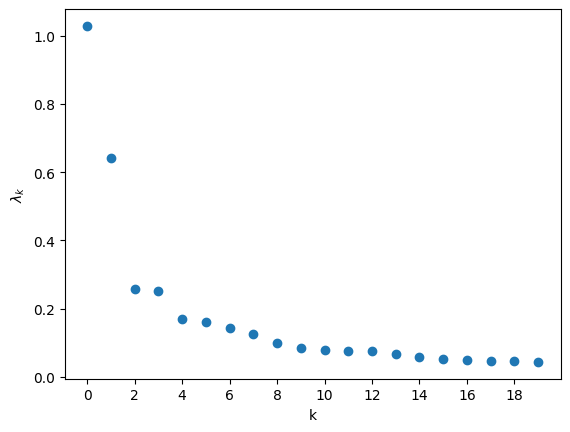

In [11]:
import matplotlib.pyplot as plt
plt.scatter(np.arange(len(e_vecs)),e_vecs[::-1])
plt.xlabel('k')
plt.ylabel('$\\lambda_k$')
plt.xticks(np.arange(len(e_vecs),step=2))
plt.show()

Interestingly, there is only one dominant eigenvalue. What could be happening? Well for that we need to visualize the data, here is an animation of the trajectories

In [2]:
from IPython.display import Video
Video("https://youtu.be/NOqUXRsFo9Q")
# Video("https://www.youtube.com/watch?v=NOqUXRsFo9Q")

As we can see the fish do align but they are constrained to move in a circular tank, therefore the group remains unpolarized, instead it swirls around the the tank. The time series in the bottom plot shows the polarization in yellow, which fluctuates rapidly around 0. The blue curve on the other hand, shows the average angular velocity. As we can see, the fluctuation are much smaller and its overall dynamics is slower than that of the individual fish. Based on this observations, we can guess that the slow mode that we obtained from the diffusion map is actually the average angular velocity. To show that this is indeed the case we take the projections of the data points onto the second eigenvector, which are the components of $\psi_2$ and compare each one of them to their corresponding angular velocity
\begin{equation}
L_i = \left\langle \mathbf{x}_i\times\mathbf{v}_i\right\rangle = \frac{1}{n}\sum_{i=1}^{n}{\mathbf{x}_i\times\mathbf{v}_i}.
\end{equation}

In [22]:
#We can extract the angular momentum from the components of the feature vectors
angular_velocity = [m[7]-m[9] for m in moment_features]

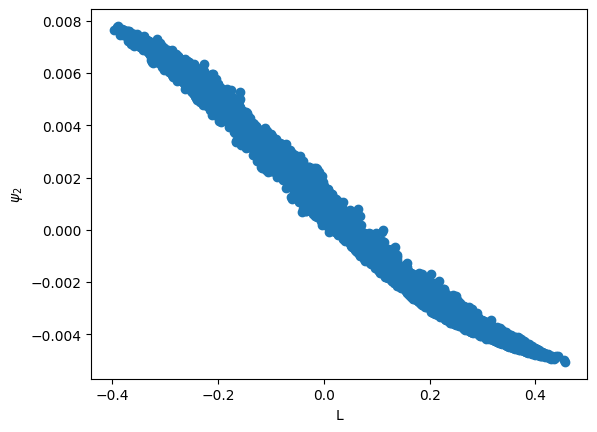

In [23]:
#Now let's plot the angular velocity against the second mode
plt.scatter(angular_velocity,modes[:,-2])
plt.xlabel('L')
plt.ylabel('$\\psi_2$')
plt.show()

As you can see, the angular velocity and the projections on the second eigenvector are linearly correlated, this suggest that the relevant collective variable for the fish group is the angular velocity. Note as well that even though we choose the statistical moments of the positions and velocities, we didn't know which of these moments correspond to the relevant collective variables and in fact none of them are, it is a linear combination of them, the one that presents slow dynamics.

The method above can also be used to identify phase transitions, when they exist. Indeed, in some cases we can change the geometry of the phase space by tuning control parameters, for example temperature, density or noise intensity. To explore this idea further we have included files containing similar data sets for groups of 80 and 60 fish. Try repeating the process above to obtain the spectrum for the smaller groups. Do not worry about the choice of $\epsilon$ for the moment, we will discuss how to choose the optimum value later in the tutorial. Compare the spectra and interpret the result. 